In [1]:
%load_ext autoreload

In [2]:
# !pip3 install -r requirements.txt

In [3]:
import torch
import os
import random
import onnx
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import L1Loss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm

from models.pilotnet import PilotNet
from data_prep.nvidia import NvidiaDataset

/gpfs/space/home/okuu/rally-challenge-24/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset_path = Path('/gpfs/space/projects/rally2023/rally-estonia-cropped-antialias')
random.seed(42)
data_dirs = os.listdir(dataset_path)[:2]
random.shuffle(data_dirs)
split_index = int(0.5 * len(data_dirs))

train_paths = [dataset_path / dir_name for dir_name in data_dirs[:split_index]]
valid_paths = [dataset_path / dir_name for dir_name in data_dirs[split_index:]]

BATCH_SIZE=512
NUM_WORKERS=2
LEARNING_RATE = 1e-3
DECAY = 1e-02
SAVE_DIR = Path('trained_models')

train_dataset = NvidiaDataset(train_paths)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                                   num_workers=NUM_WORKERS, pin_memory=True,
                                                   persistent_workers=True, collate_fn=train_dataset.collate_fn)

valid_dataset = NvidiaDataset(valid_paths)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                                   num_workers=NUM_WORKERS, pin_memory=True,
                                                   persistent_workers=False, collate_fn=train_dataset.collate_fn)

[NvidiaDataset] Using default transform: Compose(
)
/gpfs/space/projects/rally2023/rally-estonia-cropped-antialias/2021-06-14-11-43-48_e2e_rec_ss14_backwards: length=43674, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/gpfs/space/projects/rally2023/rally-estonia-cropped-antialias/2021-05-20-12-36-10_e2e_sulaoja_20_30: length=12025, filtered=1


In [5]:
def convert_pt_to_onnx(model_path):
    model = PilotNet()
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.to(device)
    model.eval()
    
    data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False,
                                            num_workers=NUM_WORKERS, pin_memory=True,
                                            persistent_workers=False)
    inputs, _, _ = next(iter(data_loader))
    frames = inputs['image'].to(device)
    sample_inputs = (frames, {})
    input_names = ['x']
    dynamic_axes = None
    output_path = Path(model_path).with_suffix('.onnx')

    torch.onnx.export(model, 
                      sample_inputs, 
                      output_path, 
                      input_names=input_names, 
                      dynamic_axes=dynamic_axes, 
                      do_constant_folding=False,
                      opset_version=9,
                      )
    onnx.checker.check_model(str(output_path))
    return str(output_path)

In [6]:
tens = next(iter(train_loader))[0]['image'][0]

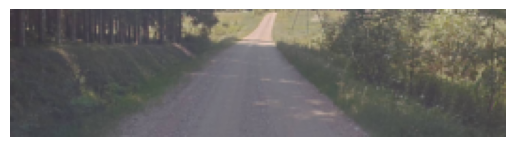

In [7]:
plt.imshow(tens.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [8]:
wandb_logging = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
criterion = L1Loss().to(device)
model = PilotNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=LEARNING_RATE,
                              betas=(0.9, 0.999),
                              eps=1e-08,
                              weight_decay=DECAY,
                              amsgrad=False)

Using device: cuda


/gpfs/space/home/okuu/rally-challenge-24/venv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [9]:
def train_epoch(model, loader, optimizer, criterion, progress_bar, epoch):
    running_loss = 0.0

    model.train()

    for i, (data, target_values, condition_mask) in enumerate(loader):

        optimizer.zero_grad()

        inputs = data['image'].to(device)
        target_values = target_values.to(device)
        predictions = model(inputs)
        loss = criterion(predictions, target_values)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        progress_bar.update(1)
        pbar_description = f'epoch {epoch+1} | train loss: {(running_loss / (i + 1)):.4f}'
        progress_bar.set_description(pbar_description)

    avg_loss = running_loss / len(loader)

    return avg_loss

In [10]:
def evaluate(model, loader, criterion, progress_bar, epoch, train_loss):
        epoch_loss = 0.0
        model.eval()
        all_predictions = []

        with torch.no_grad():
            for i, (data, target_values, condition_mask) in enumerate(loader):

                inputs = data['image'].to(device)
                target_values = target_values.to(device)
                predictions = model(inputs)
                loss = criterion(predictions, target_values)

                epoch_loss += loss.item()
                all_predictions.extend(predictions.cpu().squeeze().numpy())

                progress_bar.update(1)
                progress_bar.set_description(f'epoch {epoch + 1} | train loss: {train_loss:.4f} | valid loss: {(epoch_loss / (i + 1)):.4f}')

        total_loss = epoch_loss / len(loader)
        result = np.array(all_predictions)
        return total_loss, result

In [11]:
def calculate_whiteness(steering_angles, fps):
    current_angles = steering_angles[:-1]
    next_angles = steering_angles[1:]
    delta_angles = next_angles - current_angles

    whiteness = np.sqrt(((delta_angles * fps) ** 2).mean())
    return whiteness

def calculate_open_loop_metrics(predicted_steering, true_steering, fps):
    predicted_degrees = predicted_steering / np.pi * 180
    true_degrees = true_steering / np.pi * 180

    somewhere_middle = len(predicted_degrees) // 2

    errors_signed = predicted_degrees - true_degrees # positive means error to the left
    errors = np.abs(errors_signed)
    whiteness = calculate_whiteness(predicted_degrees, fps)
    expert_whiteness = calculate_whiteness(true_degrees, fps)

    return {
        'mae': errors.mean(),
        'rmse': np.sqrt((errors ** 2).mean()),
        'bias': errors_signed.mean(),
        'max': errors.max(),
        'whiteness': whiteness,
        'expert_whiteness': expert_whiteness
    }

def calculate_metrics(fps, predictions, valid_loader):
        frames_df = valid_loader.dataset.frames

        true_steering_angles = frames_df.steering_angle.to_numpy()
        metrics = calculate_open_loop_metrics(predictions, true_steering_angles, fps=fps)

        left_turns = frames_df["turn_signal"] == 0
        if left_turns.any():
            left_metrics = calculate_open_loop_metrics(predictions[left_turns], true_steering_angles[left_turns], fps=fps)
            metrics["left_mae"] = left_metrics["mae"]
        else:
            metrics["left_mae"] = 0

        straight = frames_df["turn_signal"] == 1
        if straight.any():
            straight_metrics = calculate_open_loop_metrics(predictions[straight], true_steering_angles[straight], fps=fps)
            metrics["straight_mae"] = straight_metrics["mae"]
        else:
            metrics["straight_mae"] = 0

        right_turns = frames_df["turn_signal"] == 2
        if right_turns.any():
            right_metrics = calculate_open_loop_metrics(predictions[right_turns], true_steering_angles[right_turns], fps=fps)
            metrics["right_mae"] = right_metrics["mae"]
        else:
            metrics["right_mae"] = 0

        return metrics

In [12]:
def train(train_loader, valid_loader, n_epoch, patience=10, fps=30, load_checkpoint=False):
    CHECKPOINT_FILENAME="checkpoint-2.pth.tar"
    
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
    
    if not load_checkpoint:
        best_valid_loss = float('inf')
        epochs_of_no_improve = 0
        epochs_passed = 0
        train_loss_list = []
        valid_loss_list = []
    else:
        checkpoint = torch.load(SAVE_DIR / CHECKPOINT_FILENAME)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        epochs_passed = checkpoint['epoch']
        best_valid_loss = checkpoint['best_valid_loss']
        epochs_of_no_improve = checkpoint['epochs_of_no_improve']
        train_loss_list = checkpoint['train_loss_list']
        valid_loss_list = checkpoint['valid_loss_list']

    for epoch in range(n_epoch - epochs_passed):
        
        progress_bar = tqdm(total=len(train_loader), smoothing=0)
        train_loss = train_epoch(model, train_loader, optimizer, criterion, progress_bar, epoch)
        train_loss_list.append(train_loss)

        progress_bar.reset(total=len(valid_loader))
        valid_loss, predictions = evaluate(model, valid_loader, criterion, progress_bar, epoch, train_loss)
        valid_loss_list.append(valid_loss)

        scheduler.step(valid_loss)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            
            torch.save(model.state_dict(), SAVE_DIR / f"best.pt")
            
            epochs_of_no_improve = 0
            best_loss_marker = '*'
        else:
            epochs_of_no_improve += 1
            best_loss_marker = ''

        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'best_valid_loss': best_valid_loss,
            'epochs_of_no_improve': epochs_of_no_improve,
            'train_loss_list': train_loss_list,
            'valid_loss_list': valid_loss_list
        }, SAVE_DIR / f"checkpoint-{epoch+epochs_passed}.pth.tar")
            
        metrics = calculate_metrics(fps, predictions, valid_loader)
        whiteness = metrics['whiteness']
        mae = metrics['mae']
        left_mae = metrics['left_mae']
        straight_mae = metrics['straight_mae']
        right_mae = metrics['right_mae']
        progress_bar.set_description(f'{best_loss_marker}epoch {epoch + 1}'
                                        f' | train loss: {train_loss:.4f}'
                                        f' | valid loss: {valid_loss:.4f}'
                                        f' | whiteness: {whiteness:.4f}'
                                        f' | mae: {mae:.4f}'
                                        f' | l_mae: {left_mae:.4f}'
                                        f' | s_mae: {straight_mae:.4f}'
                                        f' | r_mae: {right_mae:.4f}')

        if epochs_of_no_improve == patience:
            print(f'Early stopping, on epoch: {epoch + 1}.')
            break

    torch.save(model.state_dict(), SAVE_DIR / "last.pt")
    pt_models = [f'{SAVE_DIR}/last.pt', f'{SAVE_DIR}/best.pt']

    for pt_model_path in pt_models:
        model_path = convert_pt_to_onnx(pt_model_path)

    return best_valid_loss, train_loss_list, valid_loss_list

In [ ]:
best_valid_loss, train_loss_list, valid_loss_list = train(train_loader,
                                                          valid_loader,
                                                          n_epoch=100)

In [ ]:
best_valid_loss, train_loss_list, valid_loss_list = train(train_loader,
                                                          valid_loader,
                                                          n_epoch=100,
                                                          load_checkpoint=True)

epoch 1 | train loss: 0.1635:  45%|████▌     | 39/86 [00:54<01:06,  1.41s/it]

In [ ]:
print('ok')